In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import (Dense, Conv2D, Input, MaxPool2D, 
                         UpSampling2D, Concatenate, Conv2DTranspose, 
                         Dropout, Cropping2D)
import tensorflow as tf
from keras.optimizers import Adam,SGD
from keras.initializers import he_normal
from keras.models import load_model
from scipy.misc import imresize
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.measure import label as label_shape
from scipy.ndimage.interpolation import map_coordinates, zoom
import os
from keras.preprocessing.image import (array_to_img, img_to_array, 
                                       load_img, ImageDataGenerator)
from keras.callbacks import (Callback, ModelCheckpoint, CSVLogger, 
                             ReduceLROnPlateau)
import keras.backend as K
import itchat
from wechat_utils import SendMessage
from callback2 import BatchHistory
del globals()['BatchHistory']
from callback2 import BatchHistory
import random
from importlib import reload
import pickle

import pdb
import gc
import sys

Using TensorFlow backend.


/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import keras
keras.__version__

'2.0.8'

In [3]:
K.set_floatx('float16')

## Prepare the data

In [4]:
# Set the necessary directories
data_dir = '../data/train_hq/'
mask_dir = '../data/train_masks/'
data2_dir = '../data2/'
all_images = os.listdir(data_dir)

In [5]:
!mkdir tmp

mkdir: cannot create directory ‘tmp’: File exists


In [6]:
tmp_dir = './tmp/u-net-v3-small/'

In [7]:
!mkdir ./tmp/u-net-v3-small/

In [8]:
# Train validation split
train_images, validation_images = train_test_split(
    all_images, train_size=0.8, test_size=0.2)

In [16]:
# original size 1280, 1918
image_size = [1918, 1280]
input_dims = [1280, 1280]
batch_size = 1

In [10]:
# Utility function to convert greyscale images to rgb
def grey2rgb(img):
    new_img = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            new_img.append(list(img[i][j]) * 3)
    new_img = np.array(new_img).reshape(img.shape[0], img.shape[1], 3)
    return new_img

In [11]:
from data_utils import (read_image_and_mask, show_image_and_mask)

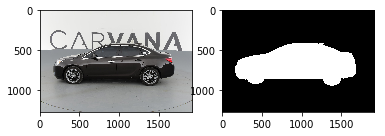

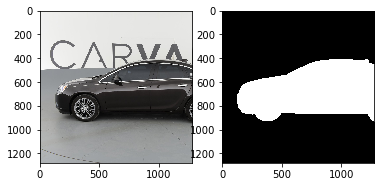

(1280, 1280)


In [44]:
from data_utils import random_crop
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = random_crop((image_, mask_), input_dims)
show_image_and_mask(image_, mask_)
print (image_.size)

In [13]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = image_.resize(image_size, resample=Image.BILINEAR)
mask_ = mask_.resize(image_size, resample=Image.BILINEAR)

CPU times: user 140 ms, sys: 8 ms, total: 148 ms
Wall time: 147 ms


In [14]:
%%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

CPU times: user 188 ms, sys: 8 ms, total: 196 ms
Wall time: 196 ms


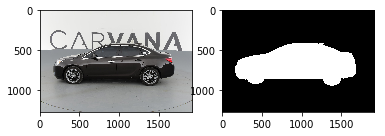

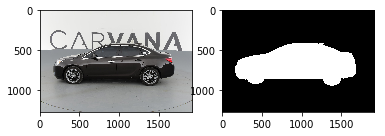

(1918, 1280)


In [18]:
from data_utils import resize_image
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = resize_image((image_, mask_), image_size)
show_image_and_mask(image_, mask_)
print (image_.size)

[[ 0  0  0  0  0  0]
 [ 0  0  1  2  2  0]
 [ 0  0  0 -3  2  0]
 [ 0 -2  2 -1 -3  0]
 [ 0 -1  1 -2 -1  0]
 [ 0  0  0  0  0  0]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  1  1  1  1  0  0]
 [ 0  0  0  0  1  1  2  2  2  2  1  0]
 [ 0  0  0  0  1  1  0  1  1  2  1  0]
 [ 0  0  0  0  0  0 -1 -1  1  2  1  0]
 [ 0  0  0  0  0  0 -2 -2  0  1  0  0]
 [ 0 -1 -1  0  1  1 -1 -2 -2 -1 -1  0]
 [ 0 -1 -2  0  1  1  0 -1 -2 -2 -1  0]
 [ 0 -1 -1  0  1  1 -1 -2 -2 -2 -1  0]
 [ 0  0 -1  0  1  0 -1 -2 -1 -1  0  0]
 [ 0  0  0  0  0  0 -1 -1 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
[array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]]), array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])]


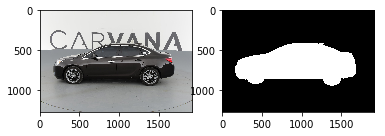

RuntimeError: data type not supported

In [19]:
def elastic_deform(image_pair, grid_size, max_range, verbose=0):
    image, mask = image_pair
    dx = np.random.randint(-max_range, high=max_range, size=grid_size)
    dy = np.random.randint(-max_range, high=max_range, size=grid_size)
    dx = np.pad(dx, mode='constant', pad_width=1)
    dy = np.pad(dy, mode='constant', pad_width=1)
    
    if verbose:
        print ('image size in opencv {}'.format(image.size))
    
    w, h = image.size
                          
    dx = imresize(dx, (h, w), mode='F')
    dy = imresize(dy, (h, w), mode='F')
    
    if verbose:
        print ('dx shape is {}'.format(dx.shape))
    
    x, y = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    
    image = img_to_array(image)
    mask = img_to_array(mask)
    
    if verbose:
        print ('image shape is {}'.format(image.shape))
        print ('image shape is {}'.format(image.shape))
    
    for i in range(3):
        # Processing by channel
        image[:,:,i] = map_coordinates(image[:,:,i], indices, order=1).reshape((h, w))
        mask[:,:,i] = map_coordinates(mask[:,:,i], indices, order=1).reshape((h, w))

    image = array_to_img(image)
    mask = array_to_img(mask)
    
    return image, mask
    
def test_zoom():
    dx = np.random.randint(-3, 3, size=(4, 4))
    dx = np.pad(dx, mode='constant', pad_width=1)
    print (dx)
    dx = zoom(dx, (8/4, 8/4), order=1)
    print (dx)
    print (np.meshgrid(np.arange(4), np.arange(4), indexing='ij'))
    
    
test_zoom()

image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = resize_image((image_, mask_), image_size)
image_, mask_ = elastic_deform((image_, mask_), (3, 3), 5)
show_image_and_mask(image_, mask_)
image_2_, mask_2_ = elastic_deform((image_, mask_), (3, 3), 8)
show_image_and_mask(image_2_, mask_2_)

diff_ = img_to_array(mask_2_) - img_to_array(mask_)
plt.figure(figsize=(20, 16))
plt.imshow(diff_)
plt.show()

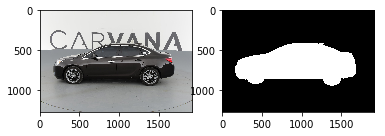

RuntimeError: data type not supported

In [20]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_deform2(image_pair, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.


    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    image, mask = image_pair
    
    image = img_to_array(image)
    mask = img_to_array(mask)
    
    shape = image.shape[0:2]

    if random_state is None:
        random_state = np.random.RandomState(None)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), 
                         sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), 
                         sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    for i in range(3):
        image[:,:,i] = map_coordinates(image[:,:,i], indices, order=1).reshape(shape)
        mask[:,:,i] = map_coordinates(mask[:,:,i], indices, order=1).reshape(shape)
        
    image = array_to_img(image)
    mask = array_to_img(mask)
        
    return image, mask
    
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_, mask_ = resize_image((image_, mask_), image_size)
image_, mask_ = elastic_deform2((image_, mask_), 5, 50)
show_image_and_mask(image_, mask_)

image_2_, mask_2_ = elastic_deform2((image_, mask_), 50, 150)
show_image_and_mask(image_2_, mask_2_)

diff_ = img_to_array(mask_2_) - img_to_array(mask_)
plt.figure(figsize=(20, 16))
plt.imshow(diff_)
plt.show()

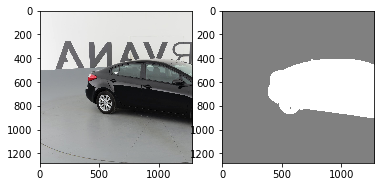

In [46]:
from data_utils import random_horizontal_flip
del globals()['random_horizontal_flip']
from data_utils import random_horizontal_flip
from data_utils import resize_image
del globals()['resize_image']
from data_utils import resize_image

transform_resize = lambda image_pair: resize_image(image_pair, image_size)
transform_flip = lambda image_pair: random_horizontal_flip(image_pair, prob=0.5)
transform_crop = lambda image_pair: random_crop(image_pair, input_dims)
transform_deform = lambda image_pair: elastic_deform(image_pair, (3, 3), 5)
transforms = [transform_resize, 
              transform_flip, 
              transform_crop]

from data_utils import data_gen_small, threadsafe_iter
import data_utils
reload(data_utils)
del globals()['data_gen_small']
from data_utils import data_gen_small
            
# Example use
train_gen = data_gen_small(data_dir, mask_dir, train_images, batch_size, 
                          input_dims, transforms=transforms)
img, msk = next(train_gen)

plt.subplot(121)
plt.imshow(img[0].astype('float32'))
plt.subplot(122)
plt.imshow(grey2rgb(msk[0].astype('float32')), alpha=0.5)

In [23]:
%%time
train_images_, train_masks_ = next(train_gen)

CPU times: user 892 ms, sys: 0 ns, total: 892 ms
Wall time: 891 ms


In [24]:
print (train_images_.shape)
print (train_masks_.shape)

(1, 1280, 1280, 3)
(1, 1280, 1280, 1)


In [25]:
val_gen = data_gen_small(data_dir, mask_dir, validation_images, batch_size, 
                         input_dims, transforms=transforms, in_order=True)

In [26]:
len(validation_images)

1018

In [78]:
for i in tqdm(range(round(1018 / batch_size + 3))):
    val_images, val_masks = next(val_gen)
    assert val_images is not None
    assert val_masks is not None

100%|██████████| 67/67 [01:59<00:00,  1.71s/it]


In [27]:
val_images, val_masks = next(val_gen)

In [28]:
print (val_images.shape)
print (val_masks.shape)

(1, 1280, 1280, 3)
(1, 1280, 1280, 1)


In [29]:
image_, mask_ = next(train_gen)
print (image_.shape)
print (mask_.shape)
print (mask_[0].shape)
print (mask_[0][150][150:180])
print (mask_[0].sum())

(1, 1280, 1280, 3)
(1, 1280, 1280, 1)
(1280, 1280, 1)
[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]
inf


## Build the network

In [30]:
# First, let's define the two different types of layers that we will 
# be using
def down(input_layer, filters, pool=True, padding='same', verbose=1):
    conv1 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   input_layer)
    residual = Conv2D(filters, (3, 3), padding=padding, 
                      kernel_initializer=he_normal(), activation='relu')(
                      conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        if verbose:
            print ('Down output shape')
            print ('max_pool {}, residual {}'.format(K.int_shape(max_pool), K.int_shape(residual)))
        return max_pool,residual
    else:
        if verbose:
            print ('Down output shape')
            print ('residual {}'.format(K.int_shape(residual)))
        return residual
    
def up(input_layer, residual, filters, padding='same', cropping=0, verbose=1):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding='same', 
                    kernel_initializer=he_normal(), activation='relu')(upsample)
    if cropping != 0:
        residual = Cropping2D(cropping=cropping)(residual)

    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding=padding,
                   kernel_initializer=he_normal(), activation='relu')(
                   concat)
    conv2 = Conv2D(filters, (3, 3), padding=padding, 
                   kernel_initializer=he_normal(), activation='relu')(
                   conv1)
    if verbose:
        print ('Up output dims')
        print (K.int_shape(conv2))
    return conv2

In [31]:
def down_block(input_layer, filters_list, dropout_list=None, padding='same'):
    residuals = []
    out = input_layer
    
    if dropout_list is None:
        dropout_list = [0] * len(filters_list)
    
    for i,filters in enumerate(filters_list):
        out, res = down(out, filters, pool=True, padding=padding)
        residuals.append(res)
        if dropout_list[i] > 0:
            out = Dropout(dropout_list[i])(out)
    return out, residuals

def up_block(input_layer, residuals, filters_list, dropout_list=None, padding='same', cropping=None):
    out = input_layer
    
    if padding == 'same':
        cropping = [0] * len(filters_list)
    if dropout_list is None:
        dropout_list = [0] * len(filters_list)
    
    for i, filters in enumerate(filters_list):
        out = up(out, residuals[::-1][i], filters, 
                 padding=padding, cropping=cropping[i])
        if dropout_list[i] > 0:
            out = Dropout(dropout[i])(out)
    return out

In [28]:
K.clear_session()
filters_list = [8, 16, 32, 64]
dropout_list = [0, 0, 0, 0.5]

input_layer = Input(shape=[None, None] + [3], dtype=K.floatx())
out, residuals = down_block(input_layer, filters_list, dropout_list)

out = down(out, 128, pool=False)
out = Dropout(0.5)(out)
out = up_block(out, residuals, filters_list[::-1])

out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(), 
             activation='sigmoid', padding='same')(out)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 8), residual (None, None, None, 8)
Down output shape
max_pool (None, None, None, 16), residual (None, None, None, 16)
Down output shape
max_pool (None, None, None, 32), residual (None, None, None, 32)
Down output shape
max_pool (None, None, None, 64), residual (None, None, None, 64)
Down output shape
residual (None, None, None, 128)
Up output dims
(None, None, None, 64)
Up output dims
(None, None, None, 32)
Up output dims
(None, None, None, 16)
Up output dims
(None, None, None, 8)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 8) 224      

In [33]:
K.clear_session()
filters_list_1 = [36, 72, 144, 288]
filters_list_2 = filters_list_1

input_layer = Input(shape=[None, None, 3], dtype=K.floatx())
out, residuals_1 = down_block(input_layer, filters_list_1)
out, residuals_2 = down_block(out, filters_list_2)
out = down(out, 64, pool=False)
out = up_block(out, residuals_2, filters_list_2[::-1])
out = up_block(out, residuals_1, filters_list_1[::-1])
out = Conv2D(filters=1, kernel_size=(1, 1), kernel_initializer=he_normal(),
             activation='sigmoid', padding='same')(out)

model = Model(input_layer, out)
model.summary()

Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 72), residual (None, None, None, 72)
Down output shape
max_pool (None, None, None, 144), residual (None, None, None, 144)
Down output shape
max_pool (None, None, None, 288), residual (None, None, None, 288)
Down output shape
max_pool (None, None, None, 36), residual (None, None, None, 36)
Down output shape
max_pool (None, None, None, 72), residual (None, None, None, 72)
Down output shape
max_pool (None, None, None, 144), residual (None, None, None, 144)
Down output shape
max_pool (None, None, None, 288), residual (None, None, None, 288)
Down output shape
residual (None, None, None, 64)
Up output dims
(None, None, None, 288)
Up output dims
(None, None, None, 144)
Up output dims
(None, None, None, 72)
Up output dims
(None, None, None, 36)
Up output dims
(None, None, None, 288)
Up output dims
(None, None, None, 144)
Up output dims
(None, None, None, 72)
Up outpu

In [ ]:
# Parameters distribution
# For convnet, parameters number = size_w * size_h * pre_depth * 
# curr_depth
# increase intial depth by 2 will result 4x params 
# Down 
# 2k 37k
# 74k 148k
# 295k 590k
# 1180k 2400k
# 4720k 9438k
# Up
# 2098k 4719k 2360k
# 524k 1180k 590k
# 131k 295k 148k
# 33k 74k 37k
# 0k last 1x1 conv
# Total, 31032k

In [ ]:
# Computation (multiply) 
# Down
# 3 * 64 * 9 * 570^2 = 561m
# 64 * 64 * 9 * 568^2 = 11893m
# 64 * 128 * 9 * 280^2 * 3 = 17340m
# 128 * 256 * 9 * 136^2 * 3 = 16264m
# 256 * 512 * 9 * 64^2 * 3 = 14496m
# 512 * 1024 * 9 * 28^2 * 3 = 11098m
# Down in all, 71652m
# Up
# 1024 * 512 * 4 * 56^2 = 6576m
# 1024 * 512 * 9 * 52^2 * 1.5 = 19139m
# 512 * 256 * 4 * 104^2 = 5671m
# 512 * 256 * 9 * 100^2 * 1.5 = 17695m
# 256 * 128 * 4 * 200^2 = 5243m
# 256 * 128 * 9 * 196^2 * 1.5 = 16994m
# 128 * 64 * 4 * 392^ 2 = 5035m
# 128 * 64 * 9 * 388^2 * 1.5 = 16648m
# Up in all, 93001m
# Omit last 1x1 conv and activation
# Total, 164653m ~ 0.16T
# Every layer, computation is almost the same, becasue the size decrease
# by a factor of 2, while filter increase by factor of 2
# Increase the filter size will significantly increase the computation
# Increase input size by 2, the number of multiplication will x4
# Increase intial depth by 2, the number of mutiplication will x4

In [34]:
# Now let's use Tensorflow to write our dice_coefficcient metric
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape((y_true), [-1]))
    y_pred = tf.round(tf.reshape((y_pred), [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

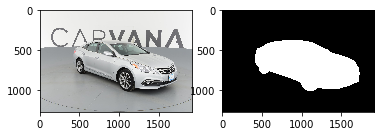

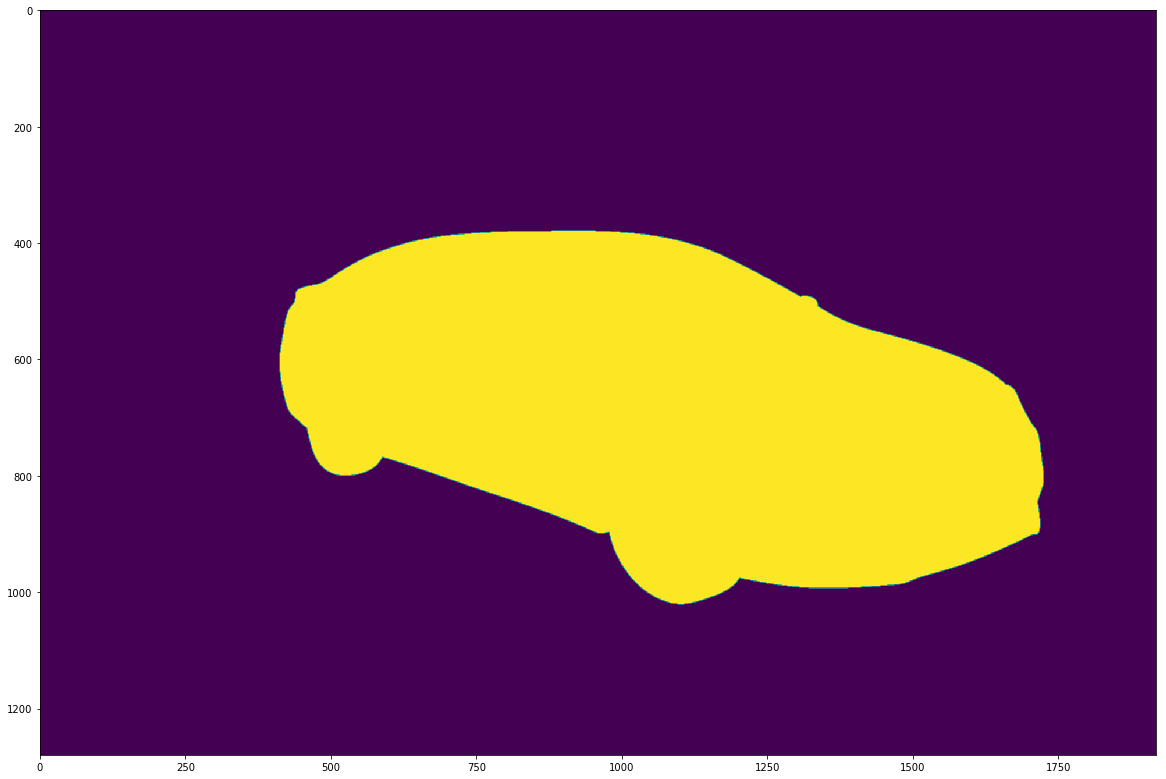

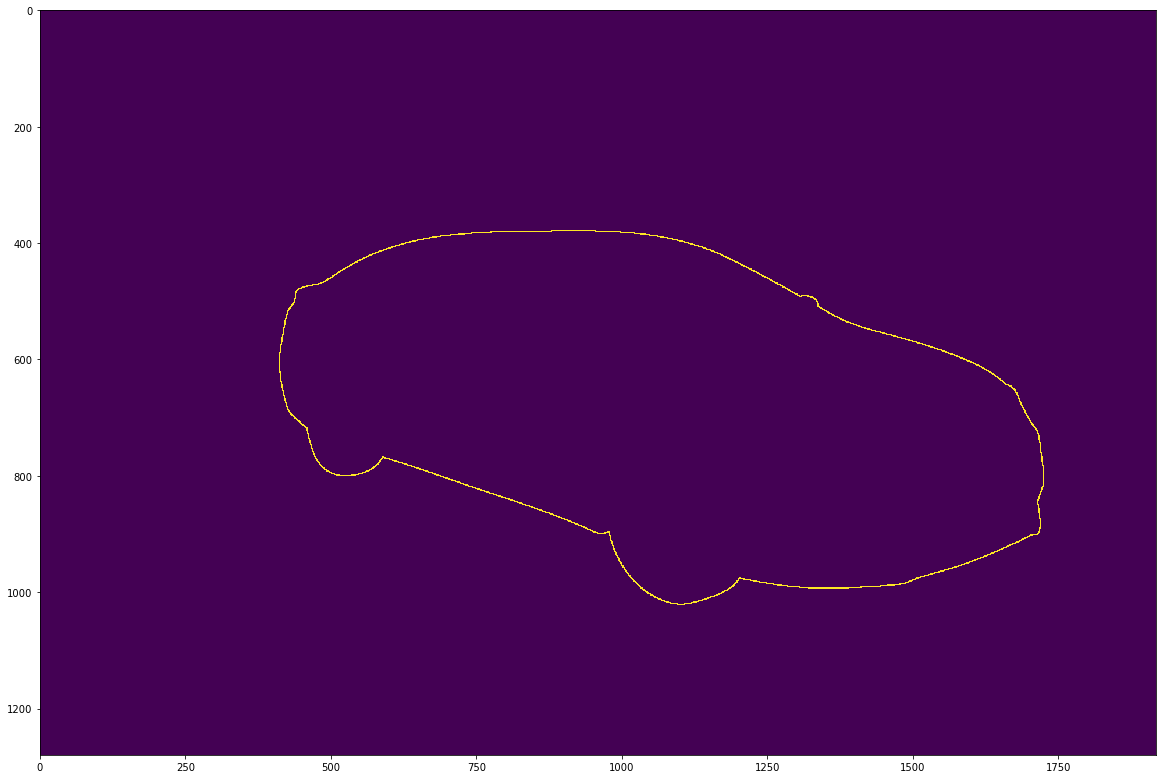

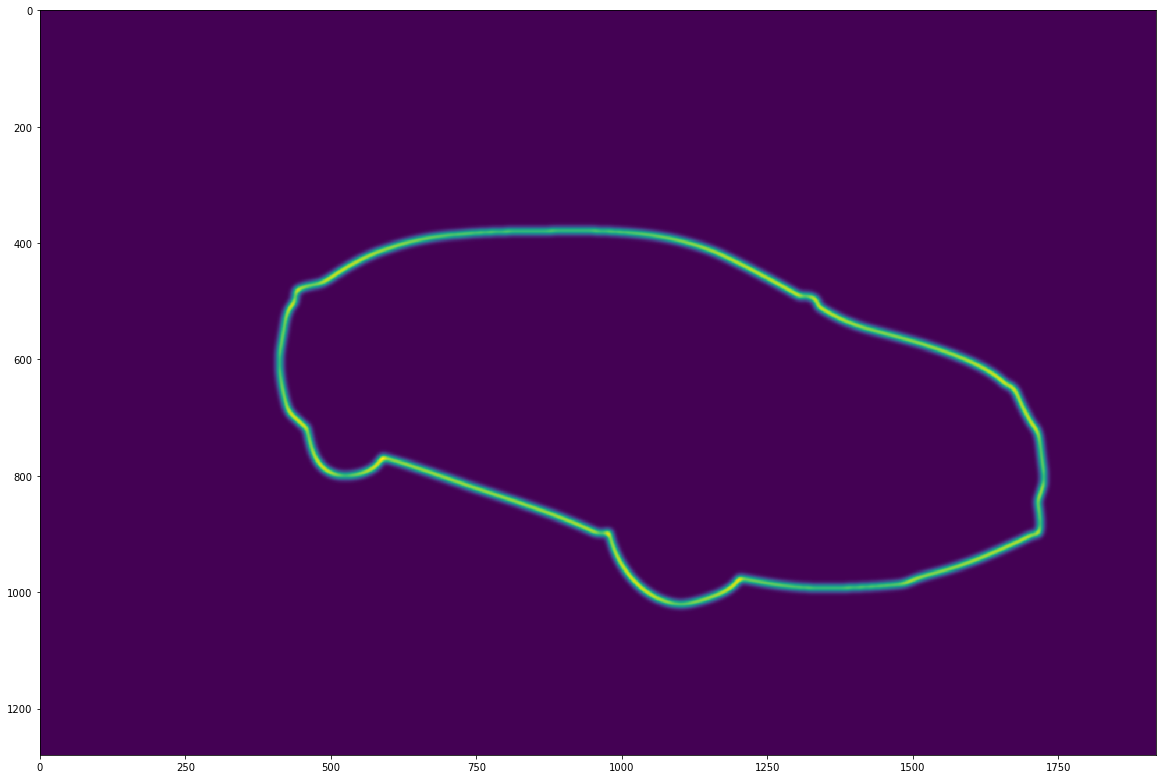

In [35]:
def tf_detect_edge(y_true, kernel_size=3, verbose=0):
    y_true_round = tf.round(y_true)
    edge_detector = tf.reshape(shape=(kernel_size, kernel_size, 1, 1), 
                               tensor=tf.ones(dtype=K.floatx(), shape=kernel_size**2))
    y_true_conv = tf.nn.conv2d(y_true_round, edge_detector, (1,1,1,1), 
                               'SAME', name='edge_detector')
    y_true_conv = tf.round(y_true_conv)
    condition1 = tf.equal(y_true_conv, 0.)
    condition2 = tf.equal(y_true_conv, kernel_size**2.)
    condition = tf.logical_or(condition1, condition2)
    edge = tf.where(condition, 
                    tf.zeros_like(y_true_conv), tf.ones_like(y_true_conv))
    if verbose:
        return y_true_conv ,edge
    else:
        return edge

def tf_gaussian_blur(edge, sigma=5):
    from scipy.ndimage import gaussian_filter
    kernel = np.zeros((sigma*8+1, sigma*8+1))
    kernel[sigma*4, sigma*4] = 1
    kernel = gaussian_filter(kernel, sigma)
    kernel = tf.constant(dtype=K.floatx(), value=kernel)
    kernel = tf.reshape(shape=(sigma*8+1, sigma*8+1, 1, 1), tensor=kernel)
    blurred = tf.nn.conv2d(edge, kernel, (1,1,1,1), 'SAME', name='blur')
    return blurred

def test_tf_blur(mask):
    ph_mask = tf.placeholder(dtype=K.floatx(), shape=(None, None, None, None))
    y_true_conv, edge = tf_detect_edge(ph_mask, verbose=1)
    blurred = tf_gaussian_blur(edge)
    with tf.Session() as sess:
        out = sess.run([y_true_conv, edge, blurred], feed_dict={ph_mask: mask})
    np.savetxt('edge.txt', out[0][0][:,:,0])
    plt.figure(figsize=(20, 16))
    plt.imshow(out[0][0][:,:,0].astype('float32'))
    plt.show()
    plt.figure(figsize=(20, 16))
    plt.imshow(out[1][0][:,:,0].astype('float32'))
    plt.show()
    plt.figure(figsize=(20, 16))
    plt.imshow(out[2][0][:,:,0].astype('float32'))
    plt.show()    

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])
mask_ = img_to_array(mask_)
test_tf_blur((mask_[None,:,:,0][:,:,:,None]/255).astype('float32'))

In [36]:
# Custome loss
def weighted_binary_crossentropy(y_true, y_pred):
    """
    # Args:
    y_true:      (batch_size, high, width, channel)
    """
    class_weight = 1
    epsilon = 1e-7
    y_pred = tf.clip_by_value(y_pred, epsilon, 1-epsilon)
    # Calculate weight
    edge = tf_detect_edge(y_true)
    blurred = tf_gaussian_blur(edge)
    boundry_weight = 10
    weight_map = 1 + (class_weight - 1) * y_true + boundry_weight * blurred
    crossentropy = - y_true * tf.log(y_pred) - (1 - y_true) * tf.log(1 - y_pred)
    weighted_loss = K.mean(crossentropy * weight_map, axis=-1)
    
    return weighted_loss

def test_weighted_loss():
    y_true = np.random.choice([0,1], size=(1,4,4,1))
    y_pred = np.random.uniform(size=(1,4,4,1))
    ph_true = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    ph_pred = tf.placeholder(dtype=tf.float32, shape=(None, None, None, None))
    op_loss = weighted_binary_crossentropy(ph_true, ph_pred)
    
    from keras.losses import binary_crossentropy
    op_naive_loss = binary_crossentropy(ph_true, ph_pred)
    with tf.Session() as sess:
        loss = sess.run([op_loss, op_naive_loss], feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('weigted loss')
        print (loss[0])
        print ('naive loss')
        print (loss[1])
        loss = sess.run(K.mean(K.binary_crossentropy(ph_true, ph_pred), axis=-1), 
                        feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('naive loss 2')
        print (loss)
        loss = sess.run(K.mean(-ph_true * tf.log(ph_pred) - (1 - ph_true) * tf.log(1 - ph_pred), axis=-1), 
                        feed_dict={ph_true: y_true, ph_pred: y_pred})
        print ('loss with prob 2')
        print (loss)
test_weighted_loss()

TypeError: Input 'filter' of 'Conv2D' Op has type float16 that does not match type float32 of argument 'input'.

In [37]:
def threshold_mask(mask):
    mask[mask >= 0.5] = 1
    mask[mask < 0.5] = 0
    return mask

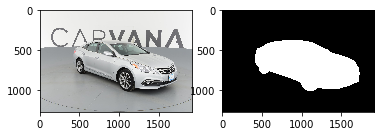

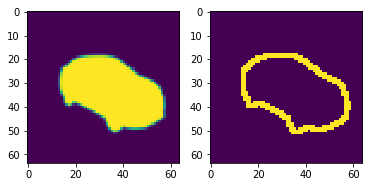

0de66245f268_15.jpg


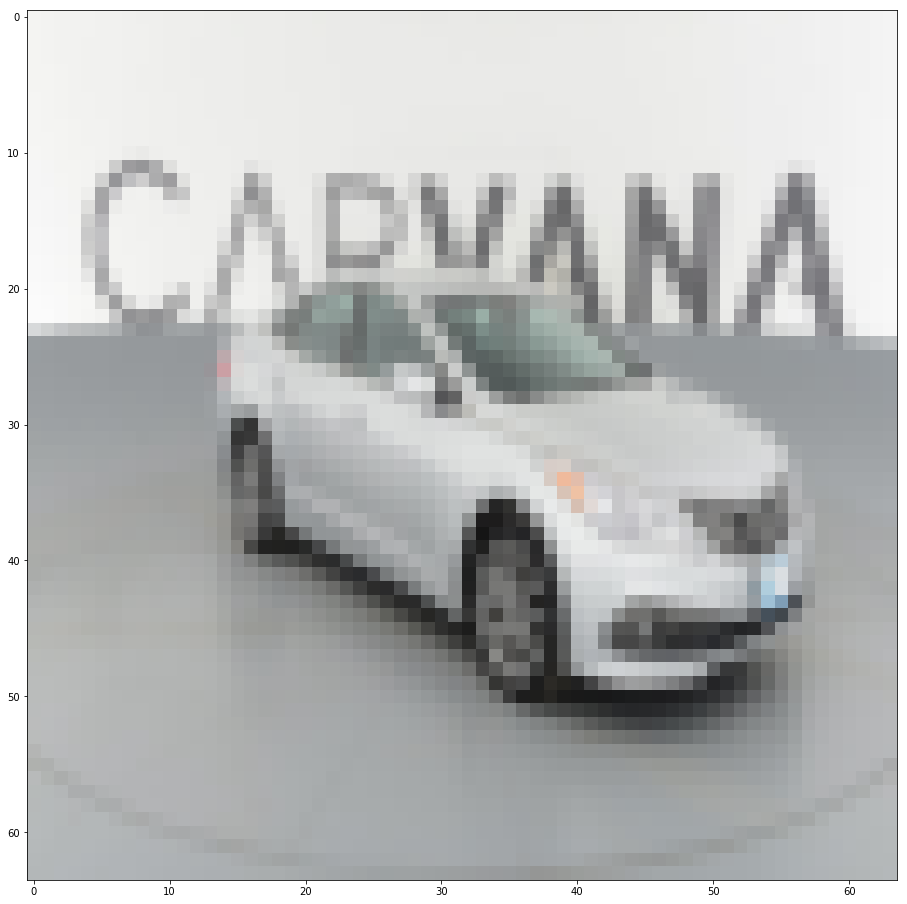

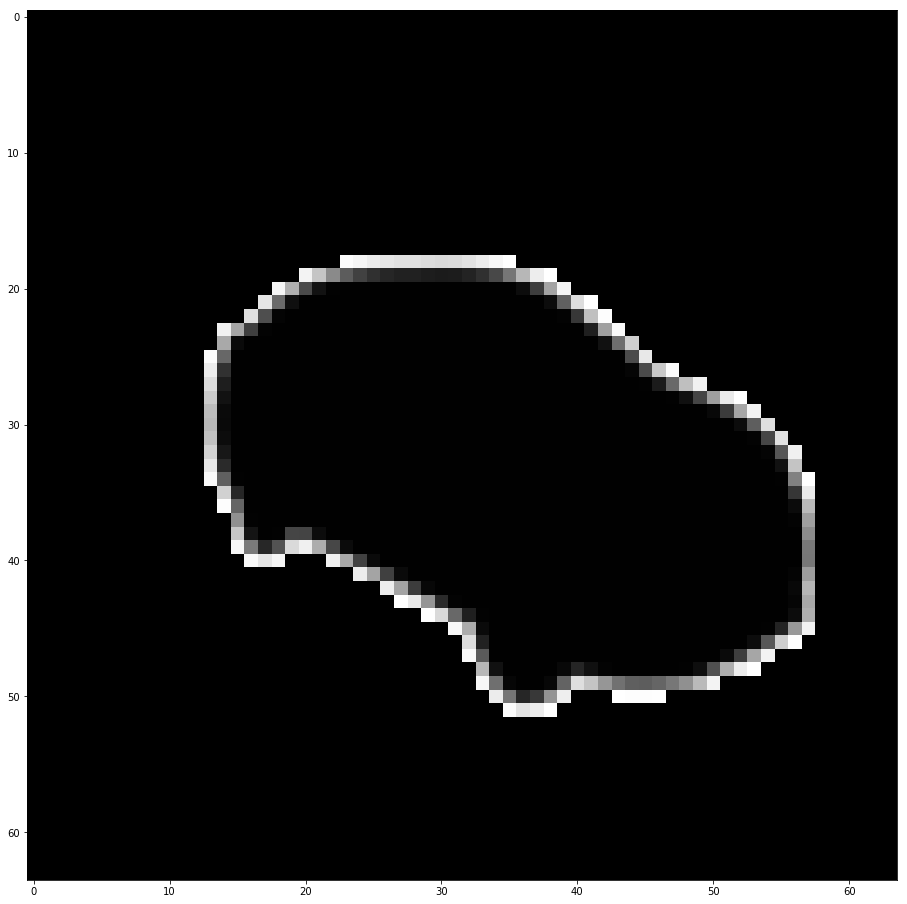

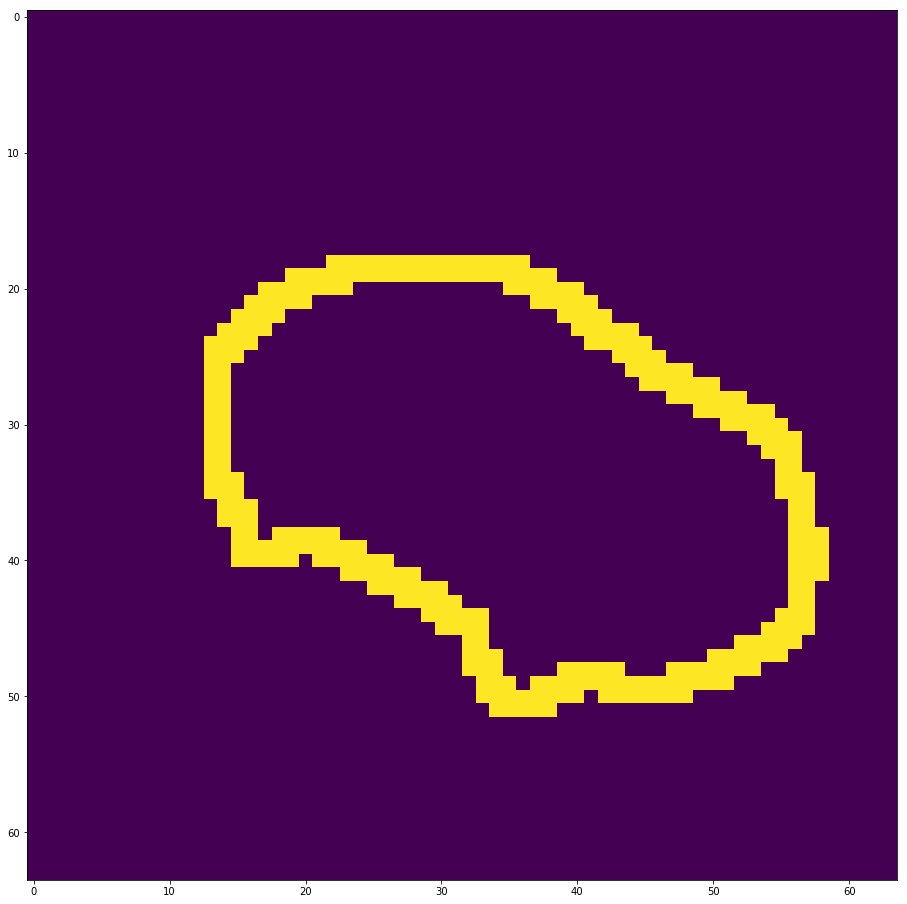

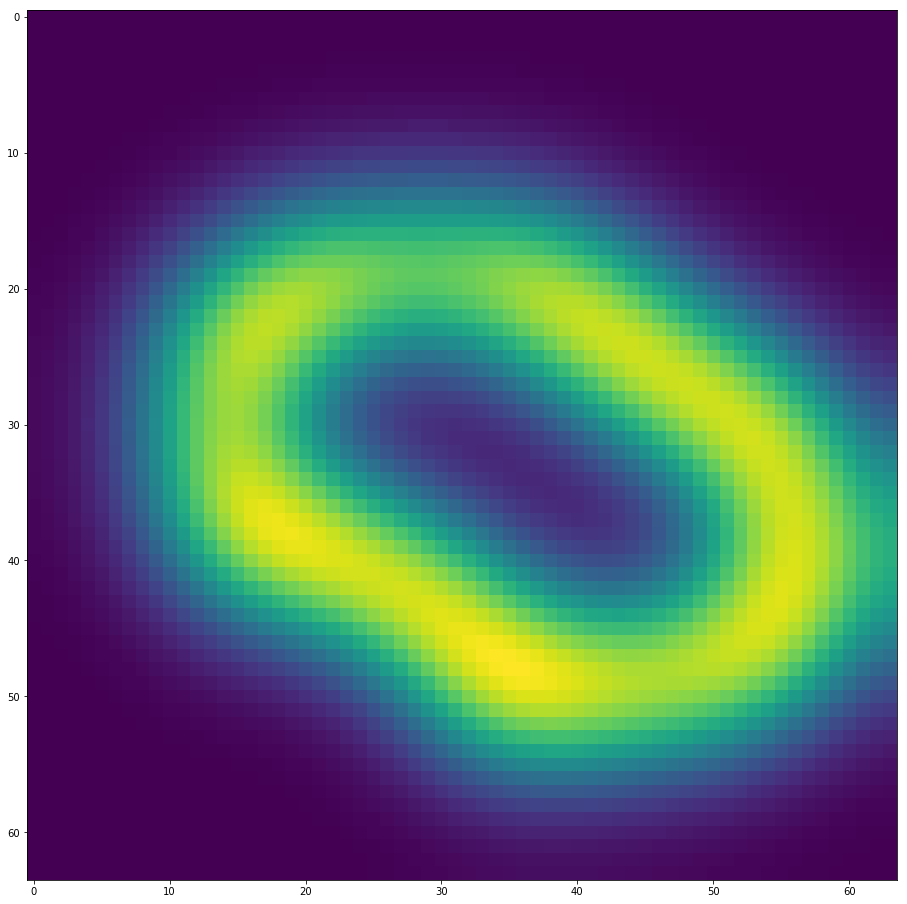

In [38]:
from scipy.signal import convolve2d
from scipy.ndimage import gaussian_filter
def detect_edge(mask, kernel_size=3, verbose=0):
    """
    # Args:
    mask:      2D array
    """
    edge_detector = np.ones(kernel_size**2).reshape((kernel_size, kernel_size))
    mask_conv = convolve2d(mask, edge_detector, 'same', 'symm')
    edge = np.ones_like(mask)
    if verbose:
        print ('show intermediate')
        plt.figure(figsize=(20, 16))
        plt.imshow(mask_conv)
        plt.show()
        np.savetxt('edge.txt', np.round(mask_conv))
    edge[mask_conv==0] = 0
    edge[mask_conv==kernel_size**2] = 0
    return edge
    
def gaussian_blur(mask, sigma=5):
    #return gaussian_filter(mask, 5)
    kernel = np.zeros((sigma*8+1, sigma*8+1))
    kernel[sigma*4, sigma*4] = 1
    kernel = gaussian_filter(kernel, sigma)
    blurred = convolve2d(mask, kernel, 'same', 'symm')
    return blurred

image_size = (64, 64)
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])
mask_ = img_to_array(mask_)
edge_ = detect_edge(threshold_mask(mask_[:,:,0]/255.))
show_image_and_mask(mask_[:,:,0].astype('float32'), edge_.astype('float32'))
#np.savetxt('edge.txt', threshold_mask(mask_[:,:,1]/255.))
print (validation_images[1])
plt.figure(figsize=(20, 16))
plt.imshow(image_)
plt.show()
plt.figure(figsize=(20, 16))
plt.imshow(mask_.astype('float32'))
plt.show()
plt.figure(figsize=(20, 16))
plt.imshow(edge_.astype('float32'))
plt.show()

edge_ = gaussian_blur(edge_)
plt.figure(figsize=(20, 16))
plt.imshow(edge_.astype('float32'))
plt.show()

In [45]:
# Must change back the image size
# original size 1280, 1918
image_size = [1918, 1280]
input_dims = [1280, 1280]
batch_size = 1

In [39]:
# Model checkpoint
checkpoint = ModelCheckpoint(filepath=tmp_dir + 'weights.hdf5',
                             verbose=1, save_best_only=True)
csv_logger = CSVLogger(tmp_dir + 'training.log')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef')

from callback2 import BatchHistory
import callback2
reload(callback2)
del globals()['BatchHistory']
from callback2 import BatchHistory

batch_history = BatchHistory(tmp_dir)

In [40]:
#optimizer = SGD(lr=0.001, momentum=0.99)
optimizer = SGD(lr=0.001, momentum=0.99)
model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, 
             metrics=[dice_coef])

In [48]:
# For keras 2.0.5, the max_queue_size should be max_q_size
# no relu in 2x2 conv, no advanced initializer
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=2, 
                              callbacks=[checkpoint, csv_logger, batch_history], 
                              validation_data=(val_images[0:2], val_masks[0:2]), 
                              validation_steps=float('inf'), 
                              max_q_size=6, 
                              workers=1, 
                              epochs=2, 
                              initial_epoch=0)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=2, callbacks=[<keras.ca..., validation_data=(array([[[..., validation_steps=inf, workers=1, epochs=2, initial_epoch=0, max_queue_size=6)`
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/2
2/2 [==============================] - 3s - loss: 0.7290 - dice_coef: nan - val_loss: 0.7261 - val_dice_coef: nan
Epoch 2/2
2/2 [==============================] - 2s - loss: 0.7300 - dice_coef: nan - val_loss: 0.7266 - val_dice_coef: nan


In [49]:
# For keras 2.0.5, the max_queue_size should be max_q_size
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=val_gen, 
                              validation_steps=1018 // batch_size + 1, 
                              max_q_size=6, 
                              workers=3, 
                              epochs=2, 
                              initial_epoch=1)

/home/paperspace/anaconda3/envs/tf11/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<data_util..., steps_per_epoch=4096.0, callbacks=[<keras.ca..., validation_data=<generator..., validation_steps=1019, workers=3, epochs=2, initial_epoch=1, max_queue_size=6)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 2/2
 346/4096 [=>............................] - ETA: 3589s - loss: inf - dice_coef: nan

KeyboardInterrupt: 

In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr, send_message], 
                              validation_data=val_gen, 
                              validation_steps=1018, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=40, 
                              initial_epoch=5)

Start auto replying.


Epoch 6/40
4096/4096 [==============================] - 4226s - loss: 0.0176 - dice_coef: 0.9950 - val_loss: 0.0175 - val_dice_coef: 0.9950
Epoch 7/40
4096/4096 [==============================] - 4225s - loss: 0.0161 - dice_coef: 0.9956 - val_loss: 0.0158 - val_dice_coef: 0.9957
Epoch 8/40
4096/4096 [==============================] - 4215s - loss: 0.0151 - dice_coef: 0.9959 - val_loss: 0.0151 - val_dice_coef: 0.9959
Epoch 9/40
4096/4096 [==============================] - 4214s - loss: 0.0145 - dice_coef: 0.9960 - val_loss: 0.0148 - val_dice_coef: 0.9958
Epoch 10/40
4096/4096 [==============================] - 4212s - loss: 0.0139 - dice_coef: 0.9962 - val_loss: 0.0148 - val_dice_coef: 0.9960
Epoch 11/40
4096/4096 [==============================] - 4217s - loss: 0.0133 - dice_coef: 0.9964 - val_loss: 0.0144 - val_dice_coef: 0.9961
Epoch 12/40
4096/4096 [==============================] - 4217s - loss: 0.0133 - dice_coef: 0.9964 - val_loss: 0.0140 - val_dice_coef: 0.9962
Epoch 13/40
4096/

In [ ]:
model.save('tmp-weights.hdf5')

In [ ]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef, 
                  'weighted_binary_crossentropy': weighted_binary_crossentropy}
model = load_model('tmp-weights.hdf5', custom_objects=custom_objects)

In [ ]:
tmp_dir

In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=val_gen, 
                              validation_steps=1019, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=52, 
                              initial_epoch=37)

In [ ]:
K.get_value(model.optimizer.lr)

In [ ]:
model.save('weights-best-in-52.hdf5')

In [ ]:
K.clear_session()
custom_objects = {'dice_coef': dice_coef, 
                  'weighted_binary_crossentropy': weighted_binary_crossentropy}
model = load_model('tmp-weights.hdf5', custom_objects=custom_objects)

In [ ]:
history = model.fit_generator(threadsafe_iter(train_gen), 
                              steps_per_epoch=4096 / batch_size, 
                              callbacks=[checkpoint, csv_logger, reduce_lr], 
                              validation_data=val_gen, 
                              validation_steps=1019, 
                              max_q_size=6, 
                              workers=1, 
                              epochs=81, 
                              initial_epoch=52)

In [ ]:
model.save(tmp_dir + 'weights-e-81.hdf5')

In [ ]:
custom_objects = {
    'dice_coef': dice_coef,
    'weighted_binary_crossentropy': weighted_binary_crossentropy
}

In [ ]:
K.clear_session()
model = load_model(tmp_dir + 'weights.hdf5', custom_objects=custom_objects)

In [ ]:
def pad_image(image, pad_width, mode='symmetric'):
    """
    Padding the image for prediction, the mode is 
    same as the one in numpy.pad
    
    # Args 
    image:      PIL Image or array
    pad_width:  the width to pad around the image
    
    # Return
                PIL Image padded
    """
    array = img_to_array(image)
    padding = ((pad_width, pad_width), (pad_width, pad_width), (0, 0))
    padded_array = np.pad(array, padding, mode=mode)
    padded_image = array_to_img(padded_array)
    return padded_image
%time
image_, mask_ = read_image_and_mask(data_dir, mask_dir, train_images[0])
show_image_and_mask(image_, mask_)
image_ = pad_image(image_, 1000)
show_image_and_mask(image_, mask_)

In [ ]:
def predict_on_patch(model, image, pad_width, mode, image_size, input_size, output_size, verbose=0):
    """
    Predict the mask patch by patch since the valid padding is used in train
    
    # Args:
    image:      PIL Image
    mode:       Method to pading the image. The same as np.pad
    image_size: The size to perform prediction, (w, h). e.g (906, 640)
    input_size: The size of image to feed into the network
    output_size:The output mask size, which is smaller than input because the edge of the 
                input is discard gradually
    
    """
    image = imresize(image, image_size[::-1])
    if pad_width != 0
        image = pad_image(image, pad_width, mode)
    array = img_to_array(image) / 255
    mask = np.zeros(image_size[::-1])
    h, w = array.shape[0:2]
    mask_h, mask_w = mask.shape
    
    patch_width = output_size[0]
    patch_high = output_size[1]
    assert patch_width == patch_high, 'Output_size must be square'
    
    input_patch_width = input_size[0]
    input_patch_high = input_size[1]
    assert input_patch_width == input_patch_high, 'Input_size must be square'
    
    if verbose:
        plt.figure()
        plt.imshow(image)
        plt.show()
    
    # Function for judge the position of the patch
    def _is_last_col():
        return patch_width * i + input_patch_width > w
    def _is_last_row():
        return patch_high * j + input_patch_high > h
    
    # Predict patch by patch
    for i in range(int(np.ceil((w - input_patch_width) / patch_width)) + 1):
        for j in range(int(np.ceil((h - input_patch_high) / patch_high)) + 1):
            
            xs = i * patch_width
            xe = xs + input_patch_width
            ys = j * patch_high
            ye = ys + input_patch_high
            
            if (_is_last_row()):
                ys = h - input_patch_high - 1
                ye = h - 1
            if (_is_last_col()):
                xs = w - input_patch_width - 1
                xe = w - 1
                
            if verbose:
                print ('Now processing ({}, {}), ({}, {}).'.
                       format(xs, ys, xe, ye))
            
            # Predict the patch
            patch = array[ys:ye, xs:xe]
            patch = patch[None,:,:,:]
            output_patch = model.predict(patch, batch_size=1)
            
            if verbose:
                show_image_and_mask(patch[0], output_patch[0,:,:,0])
            
            # Fill the mask
            xs = i * patch_width
            xe = (i + 1) * patch_width
            ys = j * patch_high
            ye = (j + 1) * patch_high
            if (_is_last_row()):
                ys = mask_h - patch_high - 1
                ye = mask_h - 1
            if (_is_last_col()):
                xs = mask_w - patch_width - 1
                xe = mask_w - 1
            mask[ys:ye, xs:xe] = output_patch[0,:,:,0]
            
    return mask

image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[0])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

output_dims = (320, 320)
mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[1])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

# Symmetric padding, (mirror)
mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[2])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

mask_pred_ = predict_on_patch(model, image_, 0, 'symmetric',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(mask_, mask_pred_)

In [ ]:
mask_pred_ = model.predict(val_images[0][None,:,:,:])
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_image_and_mask(val_masks[0][:,:,0], mask_pred_[0,:,:,0])

In [ ]:
def mirror_average_prediction(model, image, pad_width, mode, image_size, input_size, output_size):
    threshold = None
    image2 = image.transpose(Image.FLIP_LEFT_RIGHT)
    mask = predict_on_patch(model, image, pad_width, mode, image_size, input_size, output_size)
    mask2 = predict_on_patch(model, image2, pad_width, mode, image_size, input_size, output_size)
    mask = mask + np.fliplr(mask2)
    mask /= 2.
    if threshold:
        mask[mask>=threshold] = 1
        mask[mask<threshold] = 0
    return mask
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[2])
show_image_and_mask(image_, mask_)
mask_ = imresize(mask_, image_size[::-1])
mask_pred_ = mirror_average_prediction(model, image_, 0, 'edge', image_size, input_dims, output_dims)
show_image_and_mask(mask_, mask_pred_)

In [ ]:
plt.figure()
plt.imshow(mask_[:,:,0] / 255. - mask_pred_)
plt.show()
# Yellow: indicate fasle negtive
# Purper: indicate fasle positve

In [ ]:
mask_[200,200]

In [ ]:
(mask_ / 255.)[200,200,1]

In [ ]:
mask_pred_[200,200]

In [ ]:
def cal_dice_coef(mask1, mask2):
    """
    calculate dice coefficient
    
    mask1:    Groundtruth lable, size + channel
    mask2:    Predicted lable, 
    """
    if mask1.max() > 1:
        mask1 = (mask1 / 255.)[:,:,0]
    mask1 = mask1.astype(int)
    threshold = 0.5
    if threshold:
        mask2[mask2>=threshold] = 1
        mask2[mask2<threshold] = 0
        mask2 = mask2.astype(int)
    intersection = mask1 * mask2
    return 2. * intersection.sum() / (mask1 + mask2).sum()
cal_dice_coef(mask_, mask_pred_)

In [ ]:
def show_3_images(i1, i2, i3):
    plt.figure()
    plt.subplot(131)
    plt.imshow(i1)
    plt.subplot(132)
    plt.imshow(i2)
    plt.subplot(133)
    plt.imshow(i3)
    plt.show()
def show_4_images(i1, i2, i3, i4):
    plt.figure()
    plt.subplot(141)
    plt.imshow(i1)
    plt.subplot(142)
    plt.imshow(i2)
    plt.subplot(143)
    plt.imshow(i3)
    plt.subplot(144)
    plt.imshow(i4)
    plt.show()

In [ ]:
# Calculate the dice coefficient on the validation set. The mask is smaller than the image.
def val_dice_coef(model, images, masks, 
                  pad_width, image_size, input_size, output_size):
    dices = []
    masks_pred = []
    for image, mask in tqdm(zip(images, masks)):
        mask_pred = model.predict(image[None,:,:,:])
        mask_pred = mask_pred[0,:,:,:]
        dice = cal_dice_coef(mask, mask_pred)
        dices.append(dice)
        masks_pred.append([image, mask, mask_pred])
        # Show image, mask, prediction and difference
        show_4_images(image, mask[:,:,0], mask_pred[:,:,0], mask[:,:,0]-mask_pred[:,:,0])
    with open(tmp_dir + 'masks_pred.pickel', 'wb') as f:
        pickle.dump(masks_pred, f)
    dices = np.array(dices)
    return dices.mean(), mask_pred
i = 0
for val_image, val_mask in val_gen:
    mean_dice, mask_pred = val_dice_coef(model, val_images, val_masks, 
                                         0, image_size, input_dims, output_dims)
    if i == 1017:
        break

In [ ]:
def remove_artifacts(mask):
    """
    # Args:
     mask:      2D array
    """
    mask = np.round(mask)
    mask = mask.astype(np.int32)
    label = label_shape(mask, connectivity=2)
    
    (h, w) = mask.shape
    bottom_left = label[h-1,0]
    bottom_right = label[h-1,w-1]
    if bottom_left == bottom_right and bottom_left != 0:
        # Remove bottom blob
        mask[label==bottom_left] = 0
    label[label==bottom_left] = 0
    # Remove other small area
    label_num = label.max()
    areas = [(label == i + 1).sum() for i in range(label_num + 1)]
    areas_max = max(areas)
    # retain the largest blob, remove all other blobs
    for i in range(1, label_num + 1):
        if areas[i-1] != areas_max:
            mask[label==i] = 0
    return mask

ix_ = np.random.randint(0, 1018)
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[ix_])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

mask_pred_ = predict_on_patch(model, image_, 0, 'edge',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0
show_3_images(mask_, mask_pred_, mask_[:,:,0] / 255. - mask_pred_)

mask_processed_ = remove_artifacts(mask_pred_)

plt.figure(figsize=(16, 12))
plt.imshow(mask_pred_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_processed_)
plt.show()

In [ ]:
ix_ = np.random.randint(0, 1018)
print (validation_images[ix_])
image_, mask_ = read_image_and_mask(data_dir, mask_dir, validation_images[ix_])
show_image_and_mask(image_, mask_)
image_ = imresize(image_, image_size[::-1])
mask_ = imresize(mask_, image_size[::-1])

mask_pred_ = predict_on_patch(model, image_, 0, 'edge',image_size, input_dims, output_dims)
mask_pred_[mask_pred_>0.5] = 1
mask_pred_[mask_pred_<0.5] = 0

plt.figure(figsize=(16, 12))
plt.imshow(image_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_pred_)
plt.show()
plt.figure(figsize=(16, 12))
plt.imshow(mask_[:,:,0] / 255. - mask_pred_)
plt.show()
# Yellow: indicate fasle negtive, should be mask but fail to detect
# Purper: indicate fasle positve, is not car but labeled as car

In [ ]:
# Calculate the dice coefficient on the validation set. The original image will be predict part by part.
# Calculate the dice coefficient on the validation set. The original image will be predict part by part.
def val_dice_coef2(model, validation_images, data_dir, mask_dir, 
                   pad_width, mode, image_size, input_size, output_size):
    dices = []
    masks_pred = []
    for image in tqdm(validation_images):
        image, mask = read_image_and_mask(data_dir, mask_dir, image)
        mask = imresize(mask, image_size[::-1]) / 255.
        mask_pred = mirror_average_prediction(model, image, 
                                               pad_width, mode, image_size, input_dims, output_dims)
        mask_pred = remove_artifacts(mask_pred)
        # Show image, mask, prediction and difference
        show_4_images(image, mask[:,:,0], mask_pred, mask[:,:,0]-mask_pred[:,:])
        dices.append(cal_dice_coef(mask[:,:,0], mask_pred))
    with open(tmp_dir + 'masks_pred-symmetric.pickel', 'wb') as f:
        pickle.dump(masks_pred, f)
    dices = np.array(dices)
    return dices.mean(), mask_pred
mean_dice, mask_pred = val_dice_coef2(model, validation_images, data_dir, mask_dir,
                                      0, 'edge', image_size, input_dims, output_dims)

In [ ]:
mean_dice

In [ ]:
# dices.mean() = 0.9857

In [ ]:
val_batch_size = 32
for i in range(5):
    idx = random.sample(range(1018), 32)
    print (model.evaluate(val_images[idx], val_masks[idx], batch_size=4))

In [ ]:
val_batch_size = 128
for i in range(5):
    idx = random.sample(range(1018), val_batch_size)
    print (model.evaluate(val_images[idx], val_masks[idx], batch_size=4))